*** 
# Dataset #1: Abalone Data Set
*** 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import time
from pandas.plotting import scatter_matrix
from sklearn.datasets import make_classification
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_score, recall_score, r2_score, roc_auc_score
from sklearn.model_selection import cross_val_score, GridSearchCV, learning_curve, train_test_split, validation_curve, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

*** 
## DATA EXPLORATION/DISCOVERY
*** 

In [2]:
# abalone.data did not include columns
df = pd.read_csv('data/abalone.data')
df.columns = ['sex','length','diameter','height','whole weight','shucked weight','viscera weight','shell weight', 'rings']

In [3]:
# confirm number of rows and columns as indicated by UCI
df.shape

(4176, 9)

In [4]:
# check if any value are null
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4176 entries, 0 to 4175
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4176 non-null   object 
 1   length          4176 non-null   float64
 2   diameter        4176 non-null   float64
 3   height          4176 non-null   float64
 4   whole weight    4176 non-null   float64
 5   shucked weight  4176 non-null   float64
 6   viscera weight  4176 non-null   float64
 7   shell weight    4176 non-null   float64
 8   rings           4176 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


In [5]:
# get statistical summary of the dataset per each column
df.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
count,4176.000000,4176.000000,4176.000000,4176.000000,4176.00000,4176.000000,4176.000000,4176.000000
mean,0.524009,0.407892,0.139527,0.828818,0.35940,0.180613,0.238852,9.932471
std,0.120103,0.099250,0.041826,0.490424,0.22198,0.109620,0.139213,3.223601
min,0.075000,0.055000,0.000000,0.002000,0.00100,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.18600,0.093375,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799750,0.33600,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153250,0.50200,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.48800,0.760000,1.005000,29.000000


M    1527
I    1342
F    1307
Name: sex, dtype: int64


Text(0, 0.5, 'Frequency')

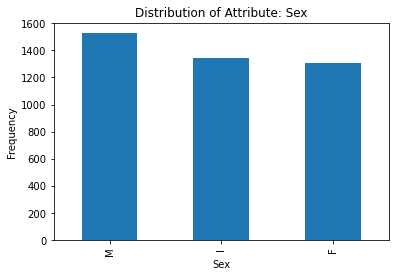

In [6]:
# determine if data is balanced in respect to target variable (sex)
print(df['sex'].value_counts())
ax = df['sex'].value_counts().plot(title='Distribution of Attribute: Sex', kind='bar')
ax.set_xlabel('Sex')
ax.set_ylabel('Frequency')

array([[<AxesSubplot:title={'center':'length'}>,
        <AxesSubplot:title={'center':'diameter'}>,
        <AxesSubplot:title={'center':'height'}>],
       [<AxesSubplot:title={'center':'whole weight'}>,
        <AxesSubplot:title={'center':'shucked weight'}>,
        <AxesSubplot:title={'center':'viscera weight'}>],
       [<AxesSubplot:title={'center':'shell weight'}>,
        <AxesSubplot:title={'center':'rings'}>, <AxesSubplot:>]],
      dtype=object)

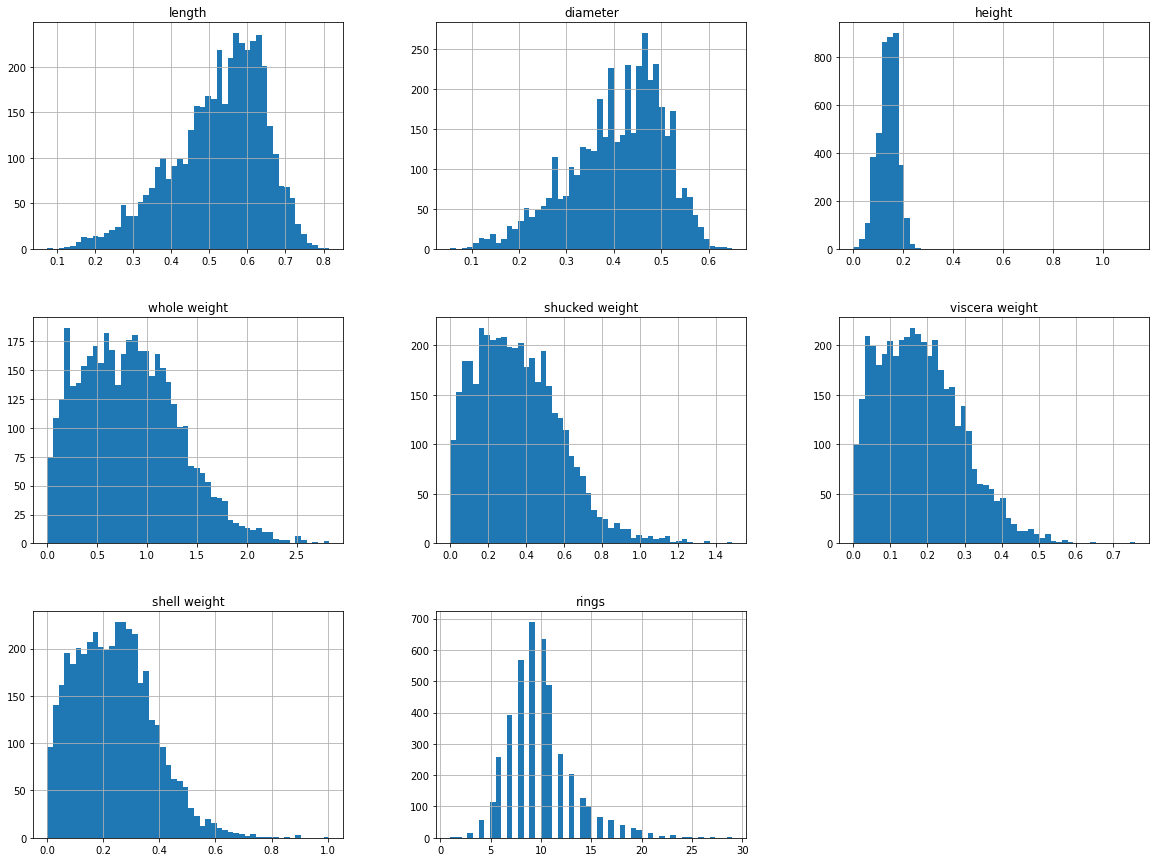

In [7]:
# understand the distribution of rest of data
df.hist(bins=50, figsize=(20,15))

*** 
## DATA PREPARATION
***

In [8]:
# X includes input/features
X = np.asarray(df.iloc[:,1:])
# y includes target class/label
y = np.asarray(df['sex'])

In [9]:
# split train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=37)

In [10]:
# standardize dataset
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

In [11]:
# confirm data after train test split
print('X_train:', X_train.shape)
print('X_test:', X_test.shape)
print('y_train:', y_train.shape)
print('y_test:', y_test.shape)

X_train: (3340, 8)
X_test: (836, 8)
y_train: (3340,)
y_test: (836,)


*** 
## Custom Functions
***

In [12]:
# plots learning curve showing performance vs. training size
def get_learning_curve_size(clf, clf_name, X, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=37), scoring="accuracy", train_sizes=np.linspace(start=0.1, stop=1.0, num=5)):
    """
    uses sklearn's learning_curve() to train clf using various sizes of training data
    
    Parameters
    ----------
    train_sizes : array-like of shape (n_ticks,) - see next line
        By default, it's [0.1   0.325 0.55  0.775 1.]
        Think of each float as percentage of total training data.
        So starts at 10%, increases by 22.5% every trial until reaching 100%
    
    cv : int, cross-validation generator/iterable
        - if int, specifies number of folds
    
    """
    sizes, training_scores, valid_scores = learning_curve(clf, X, y, cv=cv, scoring=scoring, train_sizes=train_sizes)

    # average training & validation scores
    avg_training_score = np.mean(training_scores, axis=1)
    avg_valid_scores = np.mean(valid_scores, axis=1)

    # plot and show
    plt.plot(sizes, avg_training_score, color="blue", label="Training Performance")
    plt.plot(sizes, avg_valid_scores, color="red", label="Validation Performance")
    plt.title("Training Size Learning Curve for {}".format(clf_name))
    plt.xlabel("Training Size"), plt.ylabel("Accuracy"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()
    

# plots loss curve showing loss vs. iteration
def get_loss_curve(clf, clf_name):
    """
    uses MLPClassifier's loss_curve_ attribute to plot accuracy over iterations
    purpose of this function is to plot performance over time and therefore iterations.
   
    """
    # plot and show
    loss_curve = pd.DataFrame(clf.loss_curve_)
    loss_curve = loss_curve.set_axis(['Neural Network Performance'], axis=1, inplace=False)
    loss_curve.plot()
    plt.title("Iterative Loss Curve for {}".format(clf_name))
    plt.xlabel("Iterations"), plt.ylabel("Loss"), plt.legend(loc="best")
    plt.tight_layout()
    plt.grid()
    plt.show()    

*** 
## CLASSIFICATION MODELS
***
***
### 1.1 Decision Tree
*** 

Total Training Time: 0.01697s
Total Testing Time: 0.0s
Accuracy using test set: 0.4820574162679426
Accuracy using cross-validation: 0.48300518580064755
[[102  35 124]
 [ 45 168  65]
 [112  52 133]]
              precision    recall  f1-score   support

           F       0.39      0.39      0.39       261
           I       0.66      0.60      0.63       278
           M       0.41      0.45      0.43       297

    accuracy                           0.48       836
   macro avg       0.49      0.48      0.48       836
weighted avg       0.49      0.48      0.48       836



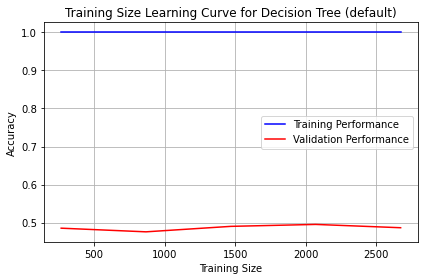

In [13]:
"""
Decision Tree (default)
"""
# initialize
dt_clf = DecisionTreeClassifier(random_state=37)
# start timer for training
start = time.time()
# train classifier
dt_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = dt_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(dt_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=dt_clf, clf_name="Decision Tree (default)", cv=skfold, scoring="accuracy", X=X_train, y=y_train)

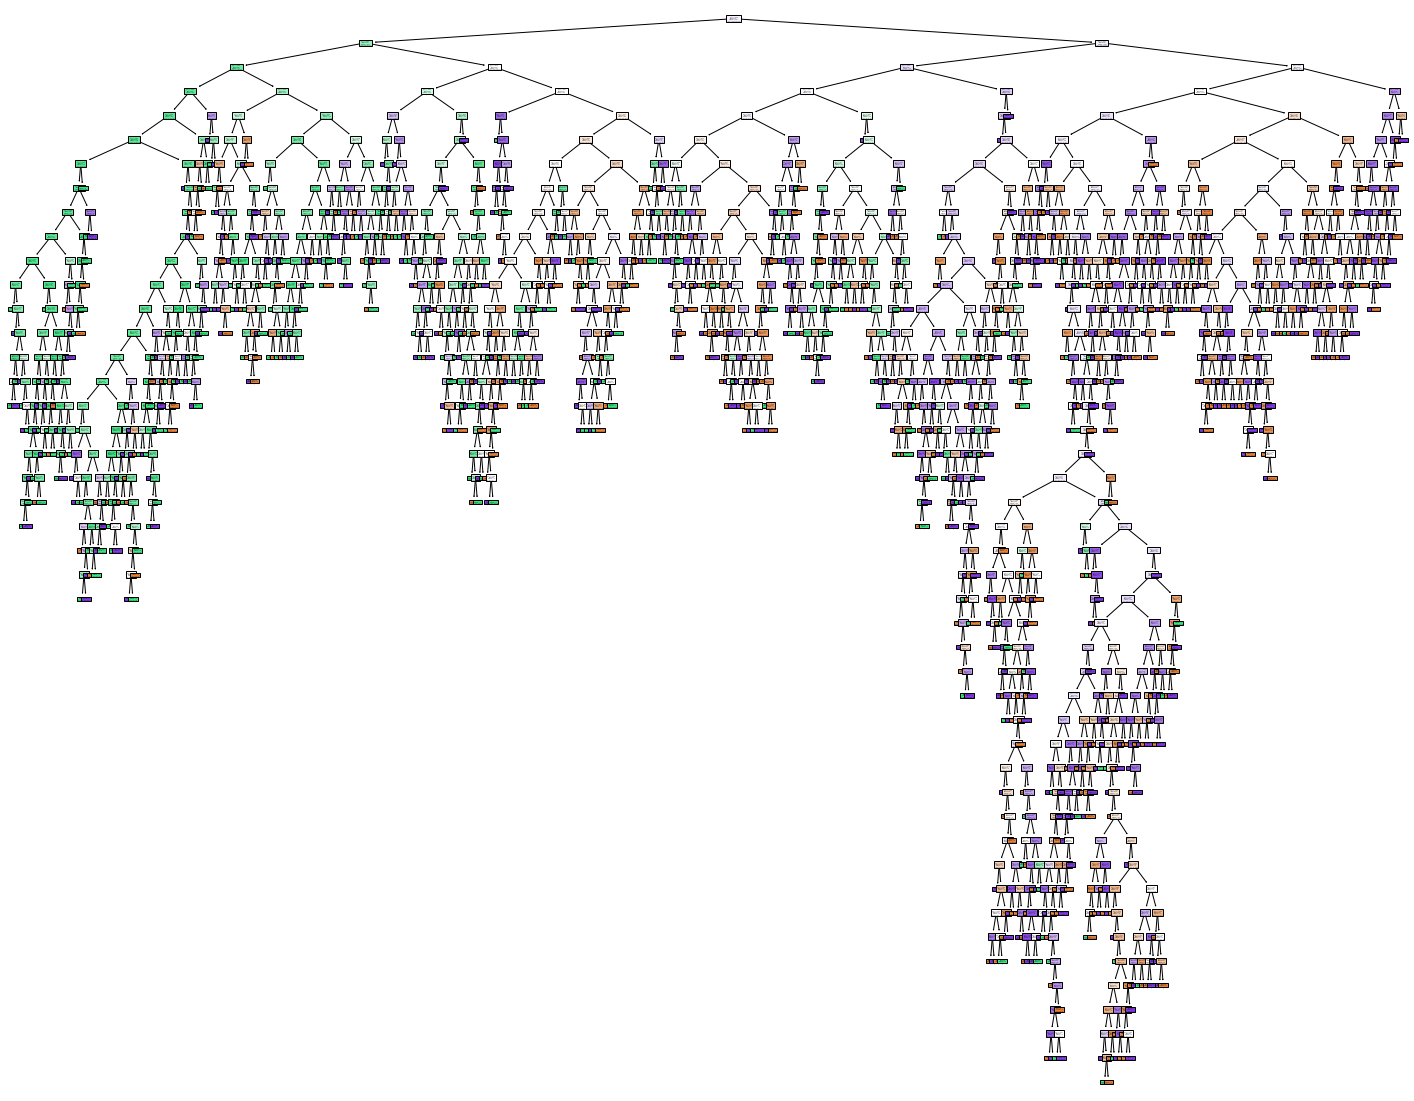

In [14]:
# visualize tree
plt.figure(figsize=(25,20))
_ = plot_tree(dt_clf, filled = True)

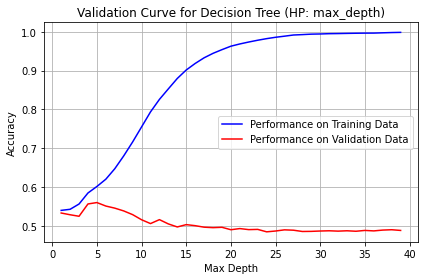

In [15]:
"""
Decision Tree (hyperparameter tuning): max_depth

Observations:
    - This made me believe that there is likely a greater max_depth in which the model isn't completely overfit
        to the training data, but improves the accuracy. 
    - It was also worth noting that the model's performance on the validation set still had not reached a plateau.
    This indicated that more data likely would increase accuracy. 
    - To test above theory, I plotted a validation curve, which indicated that at max_depth=21, the model resulted 
    in the highest accuracy on the validation set without completely overfitting the training data. By pre-pruning 
    the tree, the model stop the creation of the branches which contribute its overfits of the training data 
"""

# initialize with a seed
dt_clf = DecisionTreeClassifier(random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 40, 1)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(dt_clf, X=X_train, y=y_train, 
                                             param_name="max_depth", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Decision Tree (HP: max_depth)")
plt.xlabel("Max Depth"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

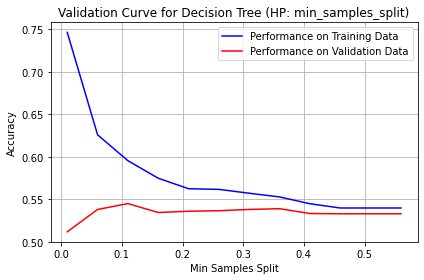

In [16]:
"""
Decision Tree (hyperparameter tuning): minimum samples split
    - This stops the tree's growth if the number of samples which gets categorized under a node it
    is less than the given threshold value. 
Observations:
    - Given the model's accuracy on the training set was still very overfit, I looked for
    other hyperparameters which would lower the overfit while keeping the accuracy high. 
    - The accuracy drops continously until levels out at minimum_samples_split = 30
    - Minimum_samples_split should not be considered as a hyperparameter as it only affects the model negatively.
"""

# initialize with a seed
dt_clf = DecisionTreeClassifier(random_state=37)

# plot validation curve using training data
# remember: param_name depends on the model being used. "max_depth" is only for Decision Trees. Use other hyperparameters for other algos
param_range = np.arange(0.01, .6, .05)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(dt_clf, X=X_train, y=y_train,
                                             param_name="min_samples_split", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Decision Tree (HP: min_samples_split)")
plt.xlabel("Min Samples Split"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

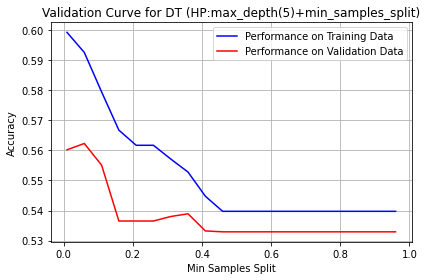

In [17]:
"""
Decision Tree (hyperparameter tuning): max_depth & minimum samples split
    - Note: Manipultion of this hyperparameter is considered pre-pruning.
    - This stops the tree's growth if the number of samples which gets categorized under a node it
    is less than the given threshold value. 
Observations:
    - Given the model's accuracy on the training set was still very overfit, I looked for
    other hyperparameters which would lower the overfit while keeping the accuracy high. 
    - The accuracy drops continously until levels out at minimum_samples_split = 30
    - Minimum_samples_split should not be considered as a hyperparameter as it only affects the model negatively.
"""

# initialize with a seed
dt_clf = DecisionTreeClassifier(random_state=37, max_depth=5)

# plot validation curve using training data
param_range = np.arange(0.01, 6, .05)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(dt_clf, X=X_train, y=y_train, 
                                             param_name="min_samples_split", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for DT (HP:max_depth(5)+min_samples_split)")
plt.xlabel("Min Samples Split"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

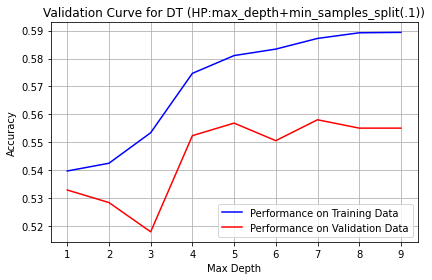

In [18]:
"""
Decision Tree (hyperparameter tuning): max_depth & minimum samples split
    - Note: Manipultion of this hyperparameter is considered pre-pruning.
    - This stops the tree's growth if the number of samples which gets categorized under a node it
    is less than the given threshold value. 
Observations:
    - Given the model's accuracy on the training set was still very overfit, I looked for
    other hyperparameters which would lower the overfit while keeping the accuracy high. 
    - The accuracy drops continously until levels out at minimum_samples_split = 30
    - Minimum_samples_split should not be considered as a hyperparameter as it only affects the model negatively.
"""

# initialize with a seed
dt_clf = DecisionTreeClassifier(random_state=37, min_samples_split=0.1)

# plot validation curve using training data
param_range = np.arange(0,10,1)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(dt_clf, X=X_train, y=y_train, 
                                             param_name="max_depth", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for DT (HP:max_depth+min_samples_split(.1))")
plt.xlabel("Max Depth"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [19]:
"""
Decision Tree (hyperparameter confirmation) using Gridsearch   
Observations:
    - Gridsearch results confirmed my result that max_depth of 21 had the highest accuracy.
    - After the experiment which showed neither min_samples_leaf nor min_samples_split has
    improves the model performance, I did not include it in the gridsearch. 
    - Additionally, having the splitter as "random" was most ideal according to grid_search.
"""

# list hyperparameters to compare
h_params = {
    'splitter': ['best', 'random'],
    'max_depth': range(1, 10),
    'min_samples_split':np.arange(0.00, 1, .05),
    'ccp_alpha': np.arange(0.0, 0.10, .1)
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(dt_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch:")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

According to gridsearch:
Best parameter values: {'ccp_alpha': 0.0, 'max_depth': 5, 'min_samples_split': 0.05, 'splitter': 'best'}
Best classifier: DecisionTreeClassifier(max_depth=5, min_samples_split=0.05, random_state=37)
Best score: 0.5604790419161676


C:\Users\JS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
90 fits failed out of a total of 1800.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
90 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 259, in fit
    raise ValueError(
ValueError: min_samples_split must be an integer greater than 1 or a float in (0.0, 1.0]; g

Total Training Time: 0.0069997311s
Total Testing Time: 0.0010004044s
Accuracy using test set: 0.5454545454545454
Accuracy using cross-validation: 0.5524387588459445
[[ 92  30 139]
 [ 29 211  38]
 [ 86  58 153]]
              precision    recall  f1-score   support

           F       0.44      0.35      0.39       261
           I       0.71      0.76      0.73       278
           M       0.46      0.52      0.49       297

    accuracy                           0.55       836
   macro avg       0.54      0.54      0.54       836
weighted avg       0.54      0.55      0.54       836



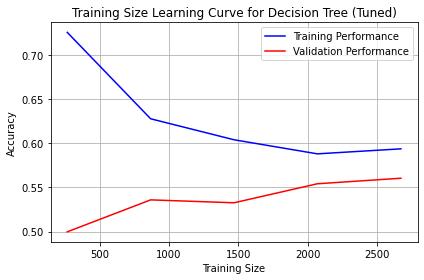

In [20]:
"""
Decision Tree - Final Learning Curve
Observations:
    - The max depth of 21 split at random using gini resulted in the highest accuracy according to gridsearch.
    - It's worth noting that I came to the conclusion that it's acceptable for the model to overfit on the 
    training set as shown in the learning curve below. It was the same data it was trained on, so it is to be expected. 
    - Given the accuracy continues to improve until the end, it is likely that additional
    data would have further improved the accuracy of the model.
    - I found it interesting that the best score given by the GridSearch results were not only 
    different from my accuracy score using the same parameters, but it was significantly lower
    compared to the accuracy score using the parameter values I found to be most optimal through
    my experiments. However, I upon research, I learned that GridSearch does its cross validation
    on the training data, and provides the best score of the test folds, whereas my measurement
    was against the test set. Therefore, there is likely to be variance. 
"""
# initialize with a seed
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.05, random_state=37, splitter='best')

# start timer for training
start = time.time()
# train classifier
dt_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 10)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = dt_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 10)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(dt_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=dt_clf, clf_name="Decision Tree (Tuned)", scoring='accuracy', X=X_train, y=y_train)

***
### 1.2 Neural Network
*** 

Total Training Time: 1.25897s
Total Testing Time: 0.001s
Accuracy using test set: 0.5334928229665071


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy using cross-validation: 0.5423788786064236
[[ 98  26 137]
 [ 21 219  38]
 [105  63 129]]
              precision    recall  f1-score   support

           F       0.44      0.38      0.40       261
           I       0.71      0.79      0.75       278
           M       0.42      0.43      0.43       297

    accuracy                           0.53       836
   macro avg       0.52      0.53      0.53       836
weighted avg       0.52      0.53      0.53       836



C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

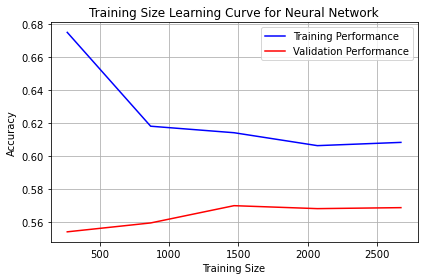

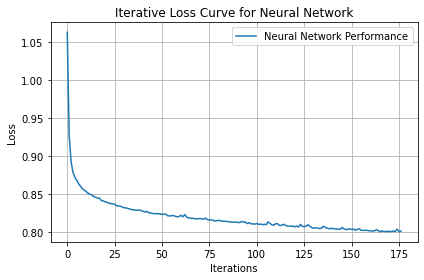

In [21]:
"""
Neural Network (Default)    
Observations:
    - Initially, the default MLPClassifier would not converge. Therefore, I had to began with the one below
    - Both the initial learning curve and the loss curve show promise.
        - learning curve shows there high training accuracy but not so high that there is overfit.
        - loss curve shows the model is learning at a steady rate. I will play with the hyper parameters to 
        see if I could help the model learn faster (reduce iterations required)
        To do this, I will experiment with the two hyper parameters, learning_rate and learning_rate_init 
    - The data needed to be scaled using StandardScaler(), given MLP is extremely sensitive to it.
"""

# initialize
mlp_clf = MLPClassifier(random_state=37)
# start timer for training
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(mlp_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=mlp_clf, clf_name="Neural Network", X=X_train, y=y_train)
# plot loss curve using using training data
get_loss_curve(clf=mlp_clf, clf_name="Neural Network")

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (101) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (201) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (301) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.

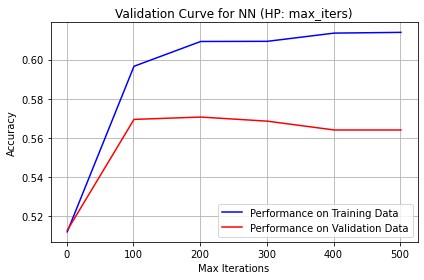

In [22]:
"""
Neural Network (hyperparameter tuning): max_iter

"""

# initialize
mlp_clf = MLPClassifier(random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 601, 100)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(mlp_clf, X=X_train, y=y_train, 
                                             param_name="max_iter", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for NN (HP: max_iters)")
plt.xlabel("Max Iterations"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


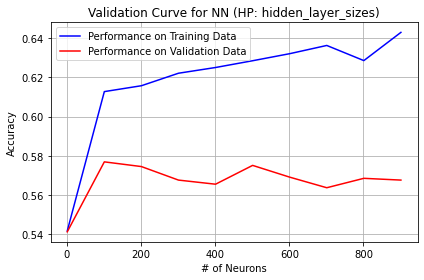

In [23]:
"""
Neural Network (hyperparameter tuning): hidden_layer_sizes (neurons)

"""

# initialize
mlp_clf = MLPClassifier(random_state=37, max_iter=200)

# plot validation curve using training data
param_range = np.arange(1, 1001, 100)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(mlp_clf, X=X_train, y=y_train, 
                                             param_name="hidden_layer_sizes", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for NN (HP: hidden_layer_sizes)")
plt.xlabel("# of Neurons"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

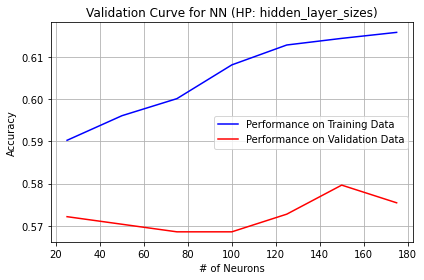

In [23]:
"""
Neural Network (hyperparameter tuning): hidden_layer_sizes (neurons)

"""

# initialize
mlp_clf = MLPClassifier(random_state=37, max_iter=200)

# plot validation curve using training data
param_range = np.arange(0, 200, 25)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(mlp_clf, X=X_train, y=y_train, 
                                             param_name="hidden_layer_sizes", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for NN (HP: hidden_layer_sizes)")
plt.xlabel("# of Neurons"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [25]:
"""
Neural Network (hyperparameter tuning): hidden_layer_sizes (hidden layers)

Observations:
    - This was used to evaluate the effect of implementing multiple hidden layers.
    - Given the param_range is difficult to adjust in validation_curve function, and since
    - no more than 3 layers need to be tested, it's worthwhile to manually run them to
    - evaluate the performance per each additional layer

"""

# hidden_layer_size = 1
mlp_clf = MLPClassifier(hidden_layer_sizes=(500), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS=1): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS=1):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size = 2
mlp_clf = MLPClassifier(hidden_layer_sizes=(500, 500), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS=2): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS=2):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size = 3
mlp_clf = MLPClassifier(hidden_layer_sizes=(500, 500, 500), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS=3): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS=3):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size increasing
mlp_clf = MLPClassifier(hidden_layer_sizes=(250, 500), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS increasing): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS increasing):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size decreasing
mlp_clf = MLPClassifier(hidden_layer_sizes=(500, 250), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS decreasing): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS decreasing):", round(accuracy_score(y_test, y_pred),5))

Total Training Time (HLS=1): 3.20471s
Accuracy (HLS=1): 0.55502


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total Training Time (HLS=2): 35.59194s
Accuracy (HLS=2): 0.53469
Total Training Time (HLS=3): 50.29049s
Accuracy (HLS=3): 0.50598


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total Training Time (HLS increasing): 15.36583s
Accuracy (HLS increasing): 0.52871
Total Training Time (HLS decreasing): 14.00906s
Accuracy (HLS decreasing): 0.50957


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [24]:
"""
Neural Network (hyperparameter tuning): hidden_layer_sizes (hidden layers) #2

Observations:
    - This was used to evaluate the effect of implementing multiple hidden layers.
    - Given the param_range is difficult to adjust in validation_curve function, and since
    - no more than 3 layers need to be tested, it's worthwhile to manually run them to
    - evaluate the performance per each additional layer

"""

# hidden_layer_size = 1
mlp_clf = MLPClassifier(hidden_layer_sizes=(150), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS=1): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS=1):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size = 2
mlp_clf = MLPClassifier(hidden_layer_sizes=(150, 150), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS=2): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS=2):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size = 3
mlp_clf = MLPClassifier(hidden_layer_sizes=(150, 150, 150), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS=3): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS=3):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size increasing
mlp_clf = MLPClassifier(hidden_layer_sizes=(75, 150), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS increasing): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS increasing):", round(accuracy_score(y_test, y_pred),5))

# hidden_layer_size decreasing
mlp_clf = MLPClassifier(hidden_layer_sizes=(150, 75), max_iter=200, random_state=37)
# start timer
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer
end = time.time()
# print total training time
print(f"Total Training Time (HLS decreasing): {round(end-start, 5)}s")
# make prediction
y_pred = mlp_clf.predict(X_test)
# evaluate model performance
print("Accuracy (HLS decreasing):", round(accuracy_score(y_test, y_pred),5))

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total Training Time (HLS=1): 2.13518s
Accuracy (HLS=1): 0.54306


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total Training Time (HLS=2): 4.67613s
Accuracy (HLS=2): 0.52751


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total Training Time (HLS=3): 7.23463s
Accuracy (HLS=3): 0.50598


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


Total Training Time (HLS increasing): 3.62652s
Accuracy (HLS increasing): 0.52871
Total Training Time (HLS decreasing): 3.49088s
Accuracy (HLS decreasing): 0.53947


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

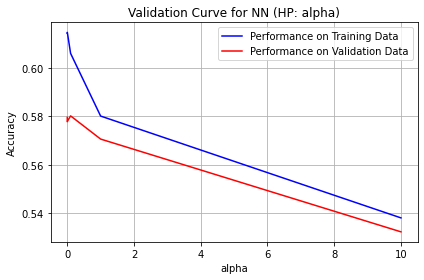

In [48]:
"""
Neural Network (hyperparameter tuning): alpha

"""

# initialize
mlp_clf = MLPClassifier(random_state=37, max_iter=200, hidden_layer_sizes=(150))

# plot validation curve using training data
param_range = [0.0001, 0.001, 0.01, 0.1, 1, 10]
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(mlp_clf, X=X_train, y=y_train, 
                                             param_name="alpha", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for NN (HP: alpha)")
plt.xlabel("alpha"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

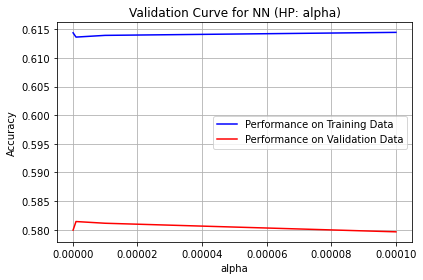

In [51]:
"""
Neural Network (hyperparameter tuning): alpha

"""

# initialize
mlp_clf = MLPClassifier(random_state=37, max_iter=200, hidden_layer_sizes=(150))

# plot validation curve using training data
param_range = [0.0000001, 0.000001, 0.00001, 0.0001]
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(mlp_clf, X=X_train, y=y_train, 
                                             param_name="alpha", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for NN (HP: alpha)")
plt.xlabel("alpha"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [53]:
"""
Neural Network (hyperparameter optimization and confirmation) using Gridsearch

"""

mlp_clf = MLPClassifier(random_state=37)

# list hyperparameters to compare
h_params = {
    #'activation': ['tanh', 'relu'],
    'alpha':[0.0000001, 0.000001, 0.00001, 0.0001],
    'hidden_layer_sizes':[
        (500),
        (400),
        (300),
        (200),
        (100),
        (50),
    ],
    'max_iter': [100, 200, 300]
    #'solver':['sgd','adam'],
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(mlp_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (100) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

According to gridsearch
Best parameter values: {'alpha': 1e-05, 'hidden_layer_sizes': 400, 'max_iter': 300}
Best classifier: MLPClassifier(alpha=1e-05, hidden_layer_sizes=400, max_iter=300,
              random_state=37)
Best score: 0.5787425149700599


Total Training Time: 5.06775s
Total Testing Time: 0.002s
Accuracy using test set: 0.5550239234449761
Accuracy using cross-validation: 0.5533997077615104
[[ 93  24 144]
 [ 21 218  39]
 [ 89  55 153]]
              precision    recall  f1-score   support

           F       0.46      0.36      0.40       261
           I       0.73      0.78      0.76       278
           M       0.46      0.52      0.48       297

    accuracy                           0.56       836
   macro avg       0.55      0.55      0.55       836
weighted avg       0.55      0.56      0.55       836



C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(
C:\Users\JS\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptro

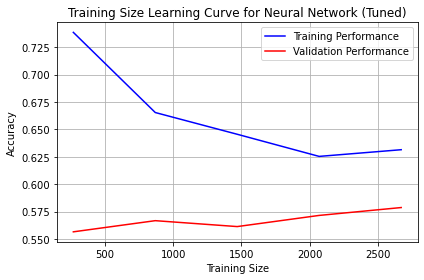

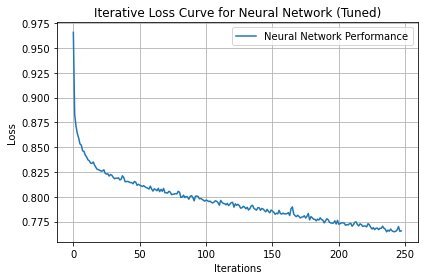

In [54]:
"""
Neural Network - Final Learning Curve

"""
# initialize with a seed

#mlp_clf = MLPClassifier(hidden_layer_sizes=(500), max_iter=100, random_state=37)
mlp_clf = MLPClassifier(hidden_layer_sizes=(400), max_iter=300, alpha=0.00001, random_state=37)


# start timer for training
start = time.time()
# train classifier
mlp_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = mlp_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(mlp_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=mlp_clf, clf_name="Neural Network (Tuned)", X=X_train, y=y_train)
# plot loss curve using using training data
get_loss_curve(clf=mlp_clf, clf_name="Neural Network (Tuned)")

***
### 1.3 Boosting
*** 

Total Training Time: 0.29703s
Total Testing Time: 0.00501s
Accuracy using test set: 0.5083732057416268
Accuracy using cross-validation: 0.5081376959000659
[[123  24 114]
 [ 44 168  66]
 [115  48 134]]
              precision    recall  f1-score   support

           F       0.44      0.47      0.45       261
           I       0.70      0.60      0.65       278
           M       0.43      0.45      0.44       297

    accuracy                           0.51       836
   macro avg       0.52      0.51      0.51       836
weighted avg       0.52      0.51      0.51       836



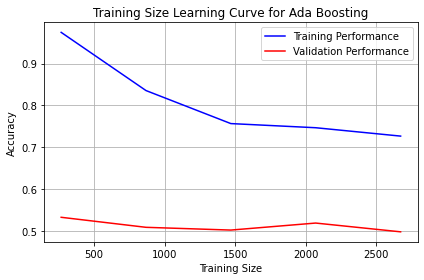

In [27]:
"""
Boosting (Default)

"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# start timer for training
start = time.time()
# train classifier
ab_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ab_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(ab_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=ab_clf, clf_name="Ada Boosting", X=X_train, y=y_train)

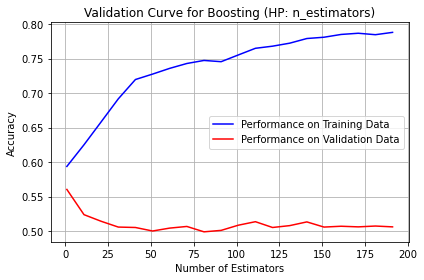

In [34]:
"""
Boosting (hyperparameter tuning): n_estimators

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - Given the power of AdaBoost comes from the ensemble of multiple learning models,
    my intuition tells me it would have the most significant impact on the performnace
    on the model. 
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=5, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 200, 10)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="n_estimators", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: n_estimators)")
plt.xlabel("Number of Estimators"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

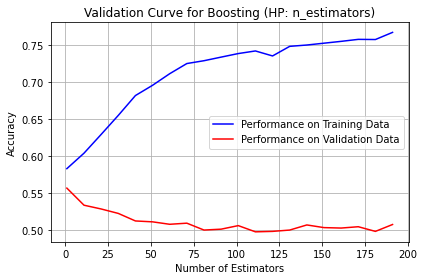

In [37]:
"""
Boosting (hyperparameter tuning): n_estimators (Part 2)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - Given the validation curve never reached a plateau when the upper bounds of estimators was 200,
    - I increased the upper limit to 1000. 
    - This experiment showed that up to n_estimators=600, the higher the number of weak learners,
    the lower the bias. This greatly helped with underfitting. 
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=4, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 200, 10)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="n_estimators", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: n_estimators)")
plt.xlabel("Number of Estimators"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

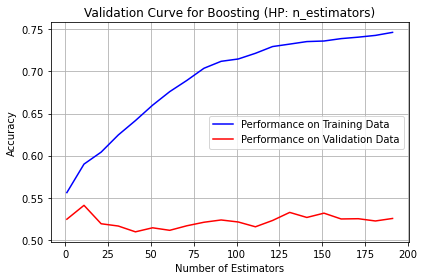

In [38]:
"""
Boosting (hyperparameter tuning): n_estimators (Part 3)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - Given the validation curve never reached a plateau when the upper bounds of estimators was 200,
    - I increased the upper limit to 1000. 
    - This experiment showed that up to n_estimators=600, the higher the number of weak learners,
    the lower the bias. This greatly helped with underfitting. 
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 200, 10)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="n_estimators", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: n_estimators)")
plt.xlabel("Number of Estimators"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

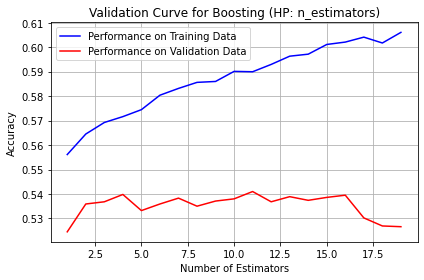

In [42]:
"""
Boosting (hyperparameter tuning): n_estimators (Part 4)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - Given the validation curve never reached a plateau when the upper bounds of estimators was 200,
    - I increased the upper limit to 1000. 
    - This experiment showed that up to n_estimators=600, the higher the number of weak learners,
    the lower the bias. This greatly helped with underfitting. 
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 20, 1)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="n_estimators", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: n_estimators)")
plt.xlabel("Number of Estimators"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

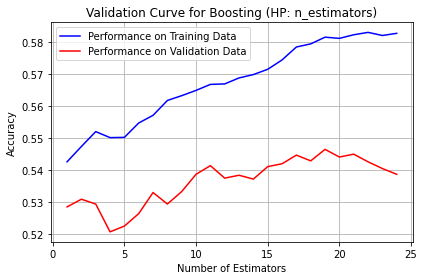

In [43]:
"""
Boosting (hyperparameter tuning): n_estimators (Part 5)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - Given the validation curve never reached a plateau when the upper bounds of estimators was 200,
    - I increased the upper limit to 1000. 
    - This experiment showed that up to n_estimators=600, the higher the number of weak learners,
    the lower the bias. This greatly helped with underfitting. 
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=2, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# plot validation curve using training data
param_range = np.arange(1, 25, 1)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="n_estimators", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: n_estimators)")
plt.xlabel("Number of Estimators"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

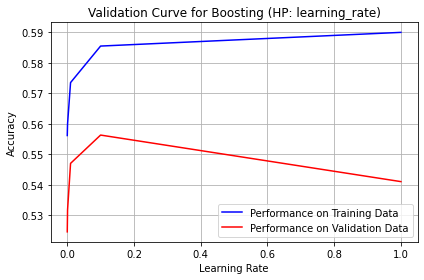

In [48]:
"""
Boosting (hyperparameter tuning): learning_rate
    - Weight applied to each classifier at each boosting iteration.
    - A higher learning rate increases the contribution of each classifier.
    - scikit docs specifically say there's a trade-off between learning_rate and n_estimators
    so next experiment I will plot them together to determine the optimal number for both

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - Per Scikitlearn, "Weight applied to each classifier at each boosting iteration. 
    A higher learning rate increases the contribution of each classifier". Tuning
    the learning_rate would speed up or slow down the "strength" of each weak learner. 
    - Given the model's tendency to underfit with its default values, my intuition was that
    reducing the learning_rate slightly would decrease the bias, leading to a better
    performing model. 
    - After plotting the validation curve, I realized my intuition was wrong. In order to find
    the exact, optimal learning rate, plotted another validation curve with the learning_rate
    set between 0 and 2. 
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37, n_estimators=11)

# plot validation curve using training data
param_range = [0.0001, 0.001, .01, .1, 1]
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="learning_rate", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: learning_rate)")
plt.xlabel("Learning Rate"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

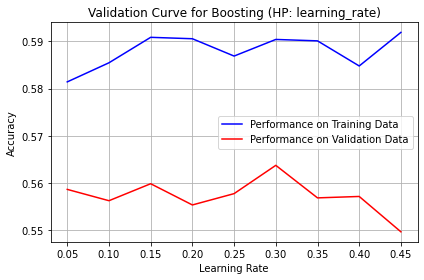

In [57]:
"""
Boosting (hyperparameter tuning): learning_rate (Part 2)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    
Observations:
    - With the below validation curve, I confirmed learning_rate of 1.5 was most optimal
    
"""

# initialize
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37, n_estimators=11)


# plot validation curve using training data
param_range = np.arange(0, 0.5, 0.05)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(ab_clf, X=X_train, y=y_train, 
                                             param_name="learning_rate", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for Boosting (HP: learning_rate)")
plt.xlabel("Learning Rate"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [33]:
"""
Boosting (hyperparameter optimization and confirmation) using Gridsearch
    - Execute gridsearch to confirm optimal hyperparameters
    - Although I was able to determine the optimal value of both n_estimators and learning_rate individually,
    my intuition was that they had an inverse relationship. Therefore, I had to solve for both hyper parameters
    simulatenously. 

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    
Observations:
    - Interestingly, according to this experiment using Gridsearch, my intuition was wrong again.
    I expected an inverse relationship, meaning, given n_estimators=800, I thought learning_rate
    would have to decrease in response. 
    - My theory is that after a certain threshold of n_estimators, learning_rate would have to decrease.
    It looks like in this case, n_estimators had not yet hit that threshold. 
"""

# initialize
dt_clf = DecisionTreeClassifier(random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37)

# list hyperparameters to compare
h_params = {
    'base_estimator__max_depth': range(1, 10),
    'base_estimator__min_samples_split': np.arange(0.00, .2, .05),
    'n_estimators': [25, 50, 100, 200, 300],
    'learning_rate': np.arange(0, 0.2, 0.05),
    'algorithm':['SAMME', 'SAMME.R']
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(ab_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

C:\Users\JS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
3150 fits failed out of a total of 7200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
1800 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 486, in fit
    return super().fit(X, y, sample_weight)
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\ensemble\_weight_boosting.py", line 114, in fit
    raise ValueError("learning_rate must be greater than z

According to gridsearch
Best parameter values: {'algorithm': 'SAMME.R', 'base_estimator__max_depth': 3, 'base_estimator__min_samples_split': 0.05, 'learning_rate': 0.1, 'n_estimators': 100}
Best classifier: AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=3,
                                                         min_samples_split=0.05,
                                                         random_state=37),
                   learning_rate=0.1, n_estimators=100, random_state=37)
Best score: 0.565568862275449


Total Training Time: 0.43171s
Total Testing Time: 0.00997s
Accuracy using holdout set: 0.52871
Accuracy using cross-validation: 0.5462263988768873


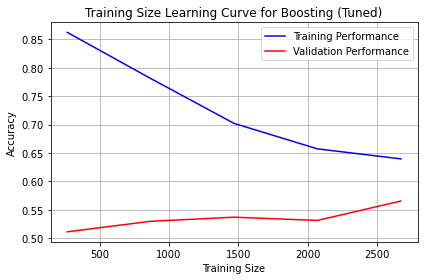

In [58]:
"""
Boosting - Final Learning Curve

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    
Observations:
    - It's interesting that the cross-validation accuracy remained exactly the same at .565.
    - According to the valuation curve, however, the biased was reduced, as shown by the increased
    performance of the model on both the training and validation sets. 
    - It's a bit concerning that accuracy on training set continues to slope downwards as training
    size increases. 
    - However, the accuracy on validation set has changed to a positive slope, meaning additional
    training data is likely to improve accuracy of the model. 
"""
# initialize
dt_clf = DecisionTreeClassifier(max_depth=3, min_samples_split=0.05, 
                                                  random_state=37)
ab_clf = AdaBoostClassifier(dt_clf, random_state=37, n_estimators=100, learning_rate=0.1)

# start timer for training
start = time.time()
# train classifier
ab_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = ab_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")


# evaluate model performance on test data (holdout)
print("Accuracy using holdout set:", round(accuracy_score(y_test, y_pred),5))
# evaluate model performance using cross-validation method
cv_scores = cross_val_score(ab_clf, X, y, cv=5)
print("Accuracy using cross-validation:", cv_scores.mean())


# plot learning curve using training and validation data
get_learning_curve_size(clf=ab_clf, clf_name="Boosting (Tuned)", X=X_train, y=y_train)

***
### 1.4 Support Vector Machines
*** 

Total Training Time: 0.23196s
Total Testing Time: 0.10404s
Accuracy using test set: 0.534688995215311
Accuracy using cross-validation: 0.5366341002206114
[[ 62  30 169]
 [ 11 216  51]
 [ 62  66 169]]
              precision    recall  f1-score   support

           F       0.46      0.24      0.31       261
           I       0.69      0.78      0.73       278
           M       0.43      0.57      0.49       297

    accuracy                           0.53       836
   macro avg       0.53      0.53      0.51       836
weighted avg       0.53      0.53      0.52       836



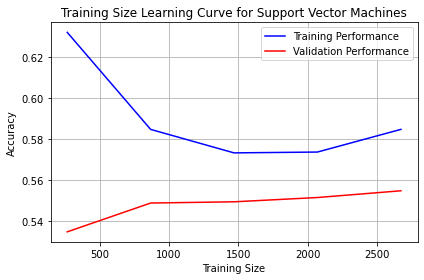

In [63]:
"""
Support Vector Machines (SVM) (Default)

Observations:
    - Using default parameters, although the model performance isn't extraordinary, the learning curve
    shows the model although slightly underfits both the training and validation sets, it is trending
    in positive direction as training size increases. 
"""

# initialize
svm_clf = SVC(random_state=37)
# start timer for training
start = time.time()
# train classifier
svm_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = svm_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(svm_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=svm_clf, clf_name="Support Vector Machines", X=X_train, y=y_train)

Linear: 0.549
Polynomial: 0.5
Radial Basis: 0.535
Sigmoid: 0.456


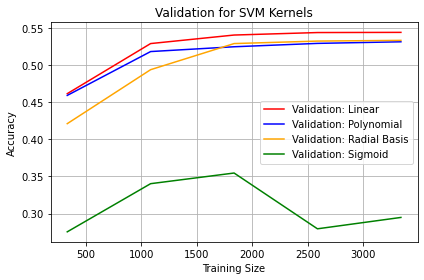

In [66]:
"""
Support Vector Machines (SVM) (hyperparameter tuning): kernel

Observations:
    - I plotted a learning curve using SVM classifiers generated using various kernels. 
    - Against both the validation set, and the test set, Radial Basis SVM was the most accurate.
        - rbf returned a cross-validation accuracy of 0.567. 
        - linear was a close second, returning a cross-validation accuracy of 0.562.
        - polynomial was a distant third, returning a cross-validation accuracy of 0.513. 
        - sigmoid was last, returning a cross-validation accuracy of 0.457, and also trending
        with a downward slope as training size increased. 
"""

# initialize
svm_clf = SVC(random_state=37)

# plot effect of kernel choice on cross-validation performance
lin_score = 0
pol_score = 0
rbf_score = 0
sig_score = 0
pre_score = 0

lin_svm_clf = SVC(random_state=37, kernel='linear')
lin_svm_clf.fit(X_train, y_train)
y_pred = lin_svm_clf.predict(X_test)
lin_score = accuracy_score(y_test,y_pred)
print("Linear:", round(lin_score, 3))

pol_svm_clf = SVC(random_state=37, kernel='poly')
pol_svm_clf.fit(X_train, y_train)
y_pred = pol_svm_clf.predict(X_test)
pol_score = accuracy_score(y_test,y_pred)
print("Polynomial:", round(pol_score, 3))

rbf_svm_clf = SVC(random_state=37, kernel='rbf')
rbf_svm_clf.fit(X_train, y_train)
y_pred = rbf_svm_clf.predict(X_test)
rbf_score = accuracy_score(y_test,y_pred)
print("Radial Basis:", round(rbf_score, 3))

sig_svm_clf = SVC(random_state=37, kernel='sigmoid')
sig_svm_clf.fit(X_train, y_train)
y_pred = sig_svm_clf.predict(X_test)
sig_score = accuracy_score(y_test,y_pred)
print("Sigmoid:", round(sig_score, 3))

counter=0
for clf in [lin_svm_clf, pol_svm_clf, rbf_svm_clf, sig_svm_clf]:
    sizes, training_scores, valid_scores = learning_curve(clf, X, y, cv=5, scoring='accuracy', train_sizes=np.linspace(start=0.1, stop=1.0, num=5))

    # average training & validation scores
    avg_training_score = np.mean(training_scores, axis=1)
    avg_valid_scores = np.mean(valid_scores, axis=1)
    
    if counter==0:
        plt.plot(sizes, avg_valid_scores, color="red", label="Validation: Linear")
    elif counter==1:
        plt.plot(sizes, avg_valid_scores, color="blue", label="Validation: Polynomial")
    elif counter==2:
        plt.plot(sizes, avg_valid_scores, color="orange", label="Validation: Radial Basis")
    elif counter==3:
        plt.plot(sizes, avg_valid_scores, color="green", label="Validation: Sigmoid")
    counter+=1
        
# plot and show
plt.title("Validation for SVM Kernels")
plt.xlabel("Training Size"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

Total Training Time: 0.24046s
Total Testing Time: 0.118s
Accuracy using test set: 0.534688995215311
Accuracy using cross-validation: 0.5366341002206114
[[ 62  30 169]
 [ 11 216  51]
 [ 62  66 169]]
              precision    recall  f1-score   support

           F       0.46      0.24      0.31       261
           I       0.69      0.78      0.73       278
           M       0.43      0.57      0.49       297

    accuracy                           0.53       836
   macro avg       0.53      0.53      0.51       836
weighted avg       0.53      0.53      0.52       836



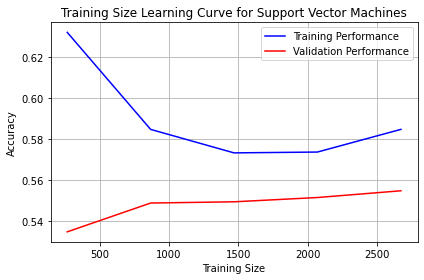

In [67]:
"""
Support Vector Machines (SVM) (Default) with "rbf"

Observations:
    - Using default parameters, although the model performance isn't extraordinary, the learning curve
    shows the model although slightly underfits both the training and validation sets, it is trending
    in positive direction as training size increases. 
"""

# initialize
svm_clf = SVC(random_state=37, kernel='rbf')
# start timer for training
start = time.time()
# train classifier
svm_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = svm_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(svm_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=svm_clf, clf_name="Support Vector Machines", X=X_train, y=y_train)

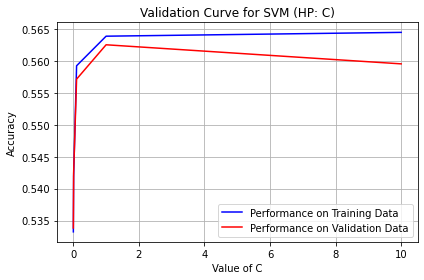

In [69]:
"""
Support Vector Machines (SVM) (hyperparameter tuning): C (linear)

Observations:

    - I tested the hyper parameter C, which measures the inverse strength of regularization. 
    - Experiment showed that at performance of the model spikes up drastically at C=0.01. 
    But it continues to increase, albeit in a much slower rate. 
    - I capped the upper limit at 1000 due to resource constraints. At C=1000, the performance
    had yet to plateau. 
    
"""

# initialize
svm_clf = SVC(random_state=37, kernel='linear')

# plot validation curve using training data
param_range = [0.001, 0.01, 0.1, 1, 10]
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(svm_clf, X=X_train, y=y_train, 
                                             param_name="C", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for SVM (HP: C)")
plt.xlabel("Value of C"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

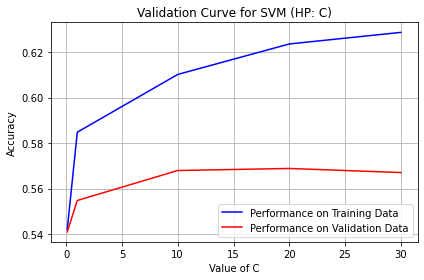

In [72]:
"""
Support Vector Machines (SVM) (hyperparameter tuning): C (rbf)

Observations:

    - I tested the hyper parameter C, which measures the inverse strength of regularization. 
    - Experiment showed that at performance of the model spikes up drastically at C=0.01. 
    But it continues to increase, albeit in a much slower rate. 
    - I capped the upper limit at 1000 due to resource constraints. At C=1000, the performance
    had yet to plateau. 
    
"""

# initialize
svm_clf = SVC(random_state=37)

# plot validation curve using training data
param_range = [0.1, 1, 10, 20, 30]
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(svm_clf, X=X_train, y=y_train, 
                                             param_name="C", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for SVM (HP: C)")
plt.xlabel("Value of C"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

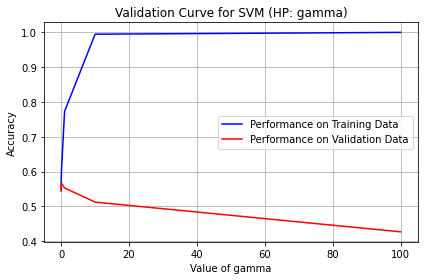

In [73]:
"""
Support Vector Machines (SVM) (hyperparameter tuning): gamma

Observations:
    - I also tested the hyper parameter gamma.
    - The higher the value of gamma, the more the model tries to fit the training data exactly.
    - This means the likelihood of overfitting increases with gamma.
    - As predicted, as the gamma value increased, the accuracy of the model on both training
    and validation data increased. The rate of increase in the accuracy on training data far exceeded
    that on validation data. 
    - In my opinion, the bias trade-off is not worth it. 
    
"""

# initialize
svm_clf = SVC(random_state=37, kernel='rbf', C=10)

# plot validation curve using training data
param_range = [0.001, 0.01, 0.1, 1, 10, 100]
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(svm_clf, X=X_train, y=y_train, 
                                             param_name="gamma", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for SVM (HP: gamma)")
plt.xlabel("Value of gamma"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

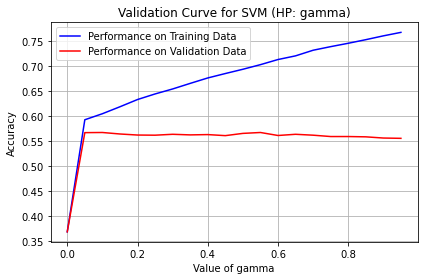

In [74]:
"""
Support Vector Machines (SVM) (hyperparameter tuning): gamma (part 2)
    
"""

# initialize
svm_clf = SVC(random_state=37, kernel='rbf', C=10)

# plot validation curve using training data
param_range = np.arange(0, 1, 0.05)
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
train_score, valid_scores = validation_curve(svm_clf, X=X_train, y=y_train, 
                                             param_name="gamma", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for SVM (HP: gamma)")
plt.xlabel("Value of gamma"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [75]:
"""
Support Vector Machines (SVM) (hyperparameter optimization and confirmation) using Gridsearch

"""

# initialize with set number of neighbors (no need for seed for this algo)
svm_clf = SVC(random_state=37, kernel='rbf')

# list hyperparameters to compare
h_params = {
    'C': [0.001, 0.01, 0.1, 1, 10, 'scale'],
    'gamma': [0.001, 0.01, 0.1, 1, 10],
    'kernel': ['linear', 'rbf']
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(svm_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return grid search results
print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

C:\Users\JS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
50 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 255, in fit
    fit(X, y, sample_weight, solver_type, kernel, random_seed=seed)
  File "C:\Users\JS\anaconda3\lib\site-packages\sklearn\svm\_base.py", line 315, in _dense_fit
    ) = libsvm.fit(
  File "sklearn\svm\_libsvm.pyx", line 58, i

According to gridsearch
Best parameter values: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best classifier: SVC(C=10, gamma=0.1, random_state=37)
Best score: 0.5667664670658683


Total Training Time: 0.22403s
Total Testing Time: 0.09503s
Accuracy using test set: 0.5382775119617225
Accuracy using cross-validation: 0.5375950491361773
[[ 73  29 159]
 [ 17 219  42]
 [ 76  63 158]]
              precision    recall  f1-score   support

           F       0.44      0.28      0.34       261
           I       0.70      0.79      0.74       278
           M       0.44      0.53      0.48       297

    accuracy                           0.54       836
   macro avg       0.53      0.53      0.52       836
weighted avg       0.53      0.54      0.53       836



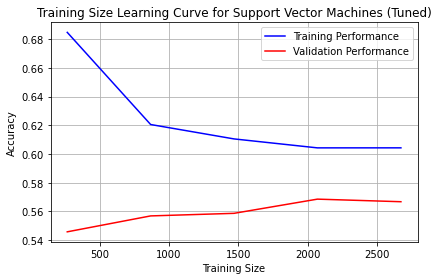

In [77]:
"""
Support Vector Machines (SVM) - Final Learning Curve
- Generate final learning curve

"""
# initialize
svm_clf = SVC(random_state=37, C=10, gamma=0.1, kernel='rbf')

# start timer for training
start = time.time()
# train classifier
svm_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = svm_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(svm_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=svm_clf, clf_name="Support Vector Machines (Tuned)", X=X_train, y=y_train)

***
### 1.5 K-Nearest Neighbors
*** 

Total Training Time: 0.009s
Total Testing Time: 0.016s
Accuracy using test set: 0.5370813397129187
Accuracy using cross-validation: 0.5282594619373693
[[119  25 117]
 [ 35 208  35]
 [118  57 122]]
              precision    recall  f1-score   support

           F       0.44      0.46      0.45       261
           I       0.72      0.75      0.73       278
           M       0.45      0.41      0.43       297

    accuracy                           0.54       836
   macro avg       0.53      0.54      0.54       836
weighted avg       0.53      0.54      0.53       836



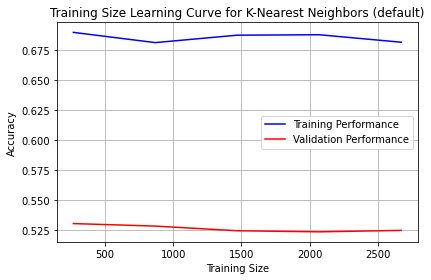

In [16]:
"""
K-Nearest Neighbors (default)

"""

# initialize
knn_clf = KNeighborsClassifier()
# start timer for training
start = time.time()
# train classifier
knn_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = knn_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(knn_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=knn_clf, clf_name="K-Nearest Neighbors (default)", cv=skfold, scoring="accuracy", X=X_train, y=y_train)

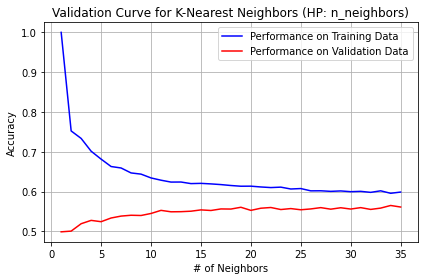

In [26]:
"""
K-Nearest Neighbors (hyperparameter tuning): n_neighbors

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Performance dropped significantly as soon as K value was increased from 1. 
"""

# initialize with set number of neighbors (no need for seed for this algo)
knn_clf = KNeighborsClassifier()

# plot validation curve using training data
param_range = np.arange(1, 36, 1)
train_score, valid_scores = validation_curve(knn_clf, X=X_train, y=y_train, 
                                             param_name="n_neighbors", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for K-Nearest Neighbors (HP: n_neighbors)")
plt.xlabel("# of Neighbors"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

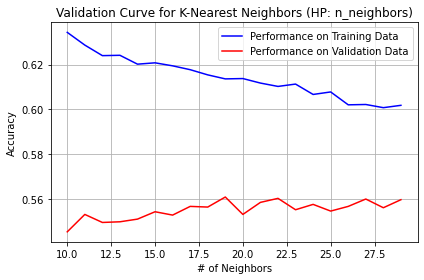

In [24]:
"""
K-Nearest Neighbors (hyperparameter tuning): n_neighbors (Part 2)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Performance dropped significantly as soon as K value was increased from 1. 
"""

# initialize
knn_clf = KNeighborsClassifier()

# plot validation curve using training data
param_range = np.arange(10, 30, 1)
train_score, valid_scores = validation_curve(knn_clf, X=X_train, y=y_train, 
                                             param_name="n_neighbors", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for K-Nearest Neighbors (HP: n_neighbors)")
plt.xlabel("# of Neighbors"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

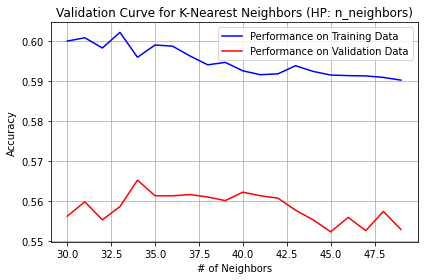

In [25]:
"""
K-Nearest Neighbors (hyperparameter tuning): n_neighbors (Part 3)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Performance dropped significantly as soon as K value was increased from 1. 
"""

# initialize
knn_clf = KNeighborsClassifier()

# plot validation curve using training data
param_range = np.arange(30, 50, 1)
train_score, valid_scores = validation_curve(knn_clf, X=X_train, y=y_train, 
                                             param_name="n_neighbors", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for K-Nearest Neighbors (HP: n_neighbors)")
plt.xlabel("# of Neighbors"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

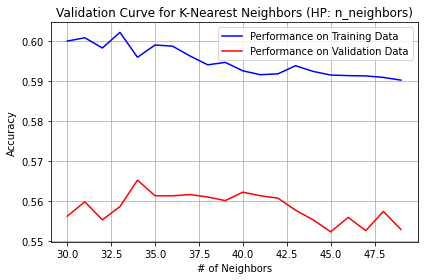

In [20]:
"""
K-Nearest Neighbors (hyperparameter tuning): n_neighbors (Part 4)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Performance dropped significantly as soon as K value was increased from 1. 
"""

# initialize
knn_clf = KNeighborsClassifier()

# plot validation curve using training data
param_range = np.arange(30, 50, 1)
train_score, valid_scores = validation_curve(knn_clf, X=X_train, y=y_train, 
                                             param_name="n_neighbors", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for K-Nearest Neighbors (HP: n_neighbors)")
plt.xlabel("# of Neighbors"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

In [27]:
"""
K-Nearest Neighbors (hyperparameter confirmation) using Gridsearch (midway confirm)

"""

# initialize
knn_clf = KNeighborsClassifier()

# list hyperparameters to compare
h_params = {
    'n_neighbors': np.arange(1, 50, 1)
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(knn_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return what grid search results
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

{'n_neighbors': 34}
KNeighborsClassifier(n_neighbors=34)
0.5652694610778444
According to gridsearch
Best parameter values: {'n_neighbors': 34}
Best classifier: KNeighborsClassifier(n_neighbors=34)
Best score: 0.5652694610778444


Total Training Time (uniform): 0.006s
Total Testing Time (uniform): 0.011s
Accuracy using test set: 0.5370813397129187
Accuracy using cross-validation: 0.5282594619373693
[[119  25 117]
 [ 35 208  35]
 [118  57 122]]
              precision    recall  f1-score   support

           F       0.44      0.46      0.45       261
           I       0.72      0.75      0.73       278
           M       0.45      0.41      0.43       297

    accuracy                           0.54       836
   macro avg       0.53      0.54      0.54       836
weighted avg       0.53      0.54      0.53       836



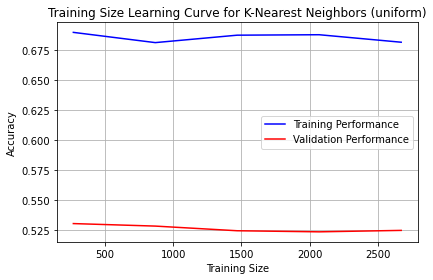

In [53]:
"""
K-Nearest Neighbors (hyperparameter tuning): weights (distance: uniform)

"""

# initialize
knn_clf = KNeighborsClassifier(weights='uniform')
# start timer for training
start = time.time()
# train classifier
knn_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time (uniform): {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = knn_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time (uniform): {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(knn_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=knn_clf, clf_name="K-Nearest Neighbors (uniform)", cv=skfold, scoring="accuracy", X=X_train, y=y_train)

Total Training Time (distance): 0.00499s
Total Testing Time (distance): 0.006s
Accuracy using test set: 0.5227272727272727
Accuracy using cross-validation: 0.5313740939174283
[[103  28 130]
 [ 28 200  50]
 [105  58 134]]
              precision    recall  f1-score   support

           F       0.44      0.39      0.41       261
           I       0.70      0.72      0.71       278
           M       0.43      0.45      0.44       297

    accuracy                           0.52       836
   macro avg       0.52      0.52      0.52       836
weighted avg       0.52      0.52      0.52       836



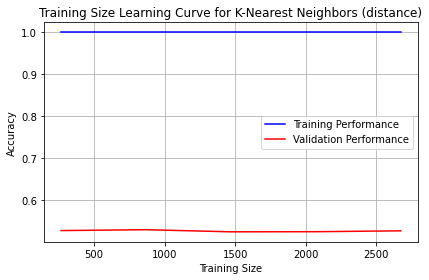

In [54]:
"""
K-Nearest Neighbors (hyperparameter tuning): weights (distance: distance)

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Given the data has already been standardized, and given the biology of abalones,
    I found it appropriate to test the difference between uniform and distance weights.
    - My prediction was that weights based on distance would result in a higher performing
    model.
    - As expected, the weights based on distances performed significantly better on 
    test data. However, it also showed complete overfit on training data, even when
    the n_neighbors=5 by default. 
"""

# initialize
knn_clf = KNeighborsClassifier(weights='distance')
# start timer for training
start = time.time()
# train classifier
knn_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time (distance): {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = knn_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time (distance): {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(knn_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=knn_clf, clf_name="K-Nearest Neighbors (distance)", cv=skfold, scoring="accuracy", X=X_train, y=y_train)

In [33]:
"""
K-Nearest Neighbors (hyperparameter confirmation) using Gridsearch

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
"""

# initialize
knn_clf = KNeighborsClassifier(weights='distance')

# list hyperparameters to compare
h_params = {
    'n_neighbors': np.arange(1, 50, 1)
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(knn_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return what grid search results
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

{'n_neighbors': 20}
KNeighborsClassifier(n_neighbors=20, weights='distance')
0.5649700598802395
According to gridsearch
Best parameter values: {'n_neighbors': 20}
Best classifier: KNeighborsClassifier(n_neighbors=20, weights='distance')
Best score: 0.5649700598802395


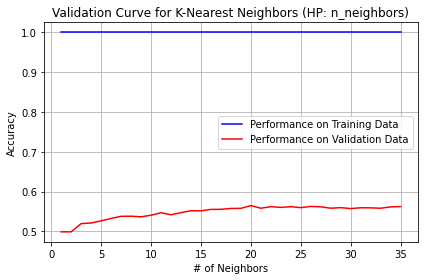

In [32]:
"""
K-Nearest Neighbors (hyperparameter tuning): n_neighbors but weights set to 'distance'

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Performance dropped significantly as soon as K value was increased from 1. 
"""

# initialize with set number of neighbors (no need for seed for this algo)
knn_clf = KNeighborsClassifier(weights='distance')

# plot validation curve using training data
param_range = np.arange(1, 36, 1)
train_score, valid_scores = validation_curve(knn_clf, X=X_train, y=y_train, 
                                             param_name="n_neighbors", param_range=param_range, cv=skfold, scoring="accuracy")

# average training & validation scores
avg_training_score = np.mean(train_score, axis=1)
avg_validation_score = np.mean(valid_scores, axis=1)

# plot and show
plt.plot(param_range, avg_training_score, color="blue", label="Performance on Training Data")
plt.plot(param_range, avg_validation_score, color="red", label="Performance on Validation Data")
plt.title("Validation Curve for K-Nearest Neighbors (HP: n_neighbors)")
plt.xlabel("# of Neighbors"), plt.ylabel("Accuracy"), plt.legend(loc="best")
plt.tight_layout()
plt.grid()
plt.show()

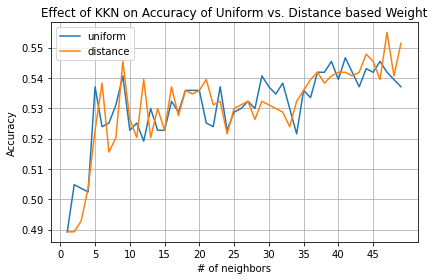

In [29]:
"""
K-Nearest Neighbors (hyper parameter tuning): n_neighbors AND weights

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - Given the entire algorithm revolves around the K value, I plotted the cross validated accuracy scores
    of the two types of weights along # of neighbors on the X-Axis. 
    - This was actually incredibly interesting. When weights are based on distance, it seems to be almost
    unaffected by n_neighbors. 
    - After thinking about it more critically, this makes sense because the when distance factors into 
    the calculation, each neighbor's proximity gets weighed more heavily than simply being within the
    vicinity. 
    - Even more interesting is that KNN using weight="distance" benefits from increasing number of neighbors
    since it's able to use the extra information provided by each neighbor more judiciously. 
"""

# plot effect of criterion & max_depth
n_neighbors = []
uni_score = []
dis_score = []
for k in range(1, 50):
    # do by uniform
    knn_clf = KNeighborsClassifier(weights='uniform', n_neighbors=k)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    uni_score.append(accuracy_score(y_test,y_pred))
    # do by distance
    knn_clf = KNeighborsClassifier(weights='distance', n_neighbors=k)
    knn_clf.fit(X_train, y_train)
    y_pred = knn_clf.predict(X_test)
    dis_score.append(accuracy_score(y_test,y_pred))
    # keep track of max_depth
    n_neighbors.append(k)

# prepare comparison data
comp_data = pd.DataFrame({
    'uniform':pd.Series(uni_score),
    'distance':pd.Series(dis_score),
    'n_neighbors':pd.Series(n_neighbors)
    })
    
# plot comparison data
plt.plot('n_neighbors', 'uniform', data=comp_data, label='uniform')
plt.plot('n_neighbors', 'distance', data=comp_data, label='distance')
plt.title("Effect of KKN on Accuracy of Uniform vs. Distance based Weight")
plt.xlabel('# of neighbors'), plt.ylabel('Accuracy'), plt.legend(loc="best")
plt.xticks(np.arange(0,50, 5))
plt.tight_layout()
plt.grid()
plt.show()

In [13]:
"""
K-Nearest Neighbors (hyper parameter confirmation) using Gridsearch
    - Execute gridsearch to confirm optimal hyperparameters
    - 

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    
Observations:
    - 
"""

# initialize
knn_clf = KNeighborsClassifier()

# list hyperparameters to compare
h_params = {
    'n_neighbors': np.arange(1, 50, 1),
    'weights':['uniform', 'distance'],
    'p':[1, 2]
}

# intialize grid search
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
grid_search = GridSearchCV(knn_clf, h_params, cv=skfold, scoring='accuracy')

# fit grid search
grid_search.fit(X_train, y_train)

# return what grid search results
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

print("According to gridsearch")
print("Best parameter values:", grid_search.best_params_)
print("Best classifier:", grid_search.best_estimator_)
print("Best score:", grid_search.best_score_)

{'leaf_size': 1, 'n_neighbors': 34, 'p': 2, 'weights': 'uniform'}
KNeighborsClassifier(leaf_size=1, n_neighbors=34)
0.5652694610778444
According to gridsearch
Best parameter values: {'leaf_size': 1, 'n_neighbors': 34, 'p': 2, 'weights': 'uniform'}
Best classifier: KNeighborsClassifier(leaf_size=1, n_neighbors=34)
Best score: 0.5652694610778444


Total Training Time: 0.00803s
Total Testing Time: 0.04866s
Accuracy using test set: 0.5215311004784688
Accuracy using cross-validation: 0.5277795604962324
[[100  29 132]
 [ 30 214  34]
 [108  67 122]]
              precision    recall  f1-score   support

           F       0.42      0.38      0.40       261
           I       0.69      0.77      0.73       278
           M       0.42      0.41      0.42       297

    accuracy                           0.52       836
   macro avg       0.51      0.52      0.52       836
weighted avg       0.51      0.52      0.52       836



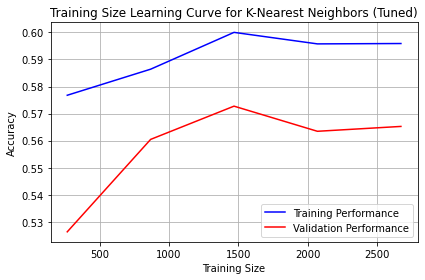

In [34]:
"""
K-Nearest Neighbors - Final Learning Curve
- Generate final learning curve

Sources:
    - https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html
    - https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html
    
Observations:
    - All experiments point to the following hyperparameters:
        - algorithm = 'auto' (default)
        - leaf_size = 1
        - n_neighbors = 1
        - p = 2 (default)
"""
# initialize with a seed
knn_clf = KNeighborsClassifier(n_neighbors=34, p=2, leaf_size=1, weights='uniform')

# start timer for training
start = time.time()
# train classifier
knn_clf.fit(X_train, y_train)
# end timer for training
end = time.time()
# print total time for training
print(f"Total Training Time: {round(end-start, 5)}s")

# start timer for testing
start = time.time()
# make prediction
y_pred = knn_clf.predict(X_test)
# end timer for testing
end = time.time()
# print total time for testing
print(f"Total Testing Time: {round(end-start, 5)}s")

# evaluate model performance on test data
print("Accuracy using test set:", accuracy_score(y_test, y_pred))
# evaluate model performance using cross-validation
skfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=37)
cv_scores = cross_val_score(knn_clf, X, y, cv=skfold, scoring='accuracy')
print("Accuracy using cross-validation:", cv_scores.mean())
# evaluate model performance using confusion_matrix
print(confusion_matrix(y_test, y_pred))
# evaluate model performance using classification_report
print(classification_report(y_test, y_pred))

# plot learning curve using training and validation data
get_learning_curve_size(clf=knn_clf, clf_name="K-Nearest Neighbors (Tuned)", scoring='accuracy', X=X_train, y=y_train)